## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [59]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string

import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from wordcloud import WordCloud  # for word cloud visualization

# Sklearn feature extraction and other utilities

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file
f = open('complaints.json', 'r')# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.
print("Number of complaints:", df.shape[0])
df.head(2)


Number of complaints: 78313


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [9]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#Assign new column names
df.columns = ['Index', 'Type', 'ID', 'Score', 'Tags', 'ZipCode', 'ComplaintID', 'Issue', 'Date Received', 'State', 'ConsumerDisputed', 'Product', 'CompanyResponse', 'Company', 'SubmittedVia', 'DateSentToCompany', 'CompanyPublicResponse', 'SubProduct', 'Timely', 'ComplaintWhatHappened', 'SubIssue', 'ConsumerConsentProvided']
print(df.columns)

Index(['Index', 'Type', 'ID', 'Score', 'Tags', 'ZipCode', 'ComplaintID',
       'Issue', 'Date Received', 'State', 'ConsumerDisputed', 'Product',
       'CompanyResponse', 'Company', 'SubmittedVia', 'DateSentToCompany',
       'CompanyPublicResponse', 'SubProduct', 'Timely',
       'ComplaintWhatHappened', 'SubIssue', 'ConsumerConsentProvided'],
      dtype='object')


In [13]:
df['ComplaintWhatHappened'] = df['ComplaintWhatHappened'].str.strip()  # remove leading/trailing whitespace
df['ComplaintWhatHappened'].replace('', np.nan, inplace=True)

/var/folders/9_/bvsds9vn02l2p8ds9_pgkyqr0000gq/T/ipykernel_13242/136124524.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [14]:
#Remove all rows where complaints column is nan
df.dropna(subset=['ComplaintWhatHappened'], inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    """Convert text to lowercase, remove text in square brackets, punctuation, and words containing numbers."""
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # remove content in square brackets
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # remove words containing numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

In [16]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    """Lemmatize the input text using spaCy."""
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df['cleaned_complaint'] = df['ComplaintWhatHappened'].apply(clean_text)
df['lemmatized_complaint'] = df['cleaned_complaint'].apply(lemmatize_text)

df_clean = pd.DataFrame()
df_clean['ComplaintWhatHappened'] = df['ComplaintWhatHappened']   # original raw complaint text
df_clean['lemmatized_complaint'] = df['lemmatized_complaint']


In [18]:
df_clean

,ComplaintWhatHappened,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xx xx and be te...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudule...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx ticket ...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx I call chas my xxxx xx...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...


In [20]:
#Write your function to extract the POS tags

def pos_tag(text):
  """Keep only nouns (NN) in the text."""
  doc = nlp(text)
  nouns = [token.lemma_ for token in doc if token.pos_ == 'NOUN']  # using coarse POS tag 'NOUN' for nouns
  return ' '.join(nouns)



df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaint"].apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean.head()


,ComplaintWhatHappened,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xx xx and be te...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudule...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...


In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,ComplaintWhatHappened,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xx xx and be te...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudule...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx I call chas my xxxx xx...,credit card provider claim purchase protection...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom problem b...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




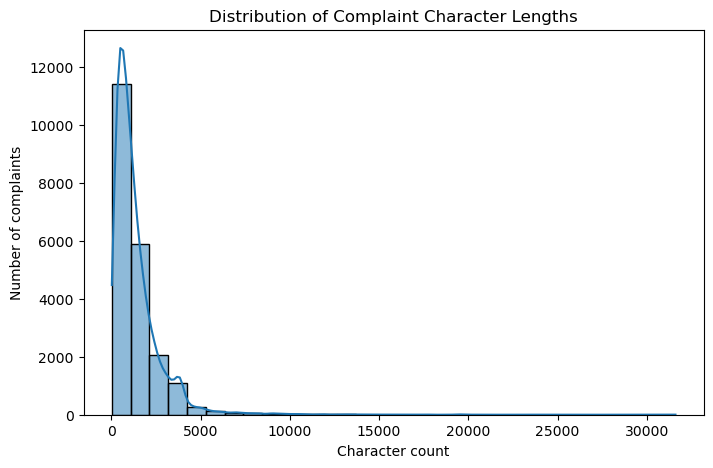

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character 
df_clean['char_length'] = df_clean['ComplaintWhatHappened'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df_clean['char_length'], bins=30, kde=True)
plt.title("Distribution of Complaint Character Lengths")
plt.xlabel("Character count")
plt.ylabel("Number of complaints")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

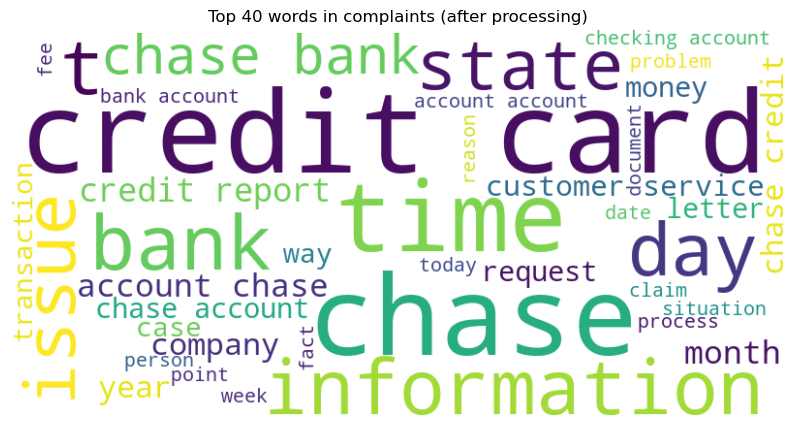

In [28]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_words = ' '.join(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color="white").generate(all_words)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 40 words in complaints (after processing)")
plt.show()


In [29]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [30]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
cv_uni = CountVectorizer(ngram_range=(1,1))
X_uni = cv_uni.fit_transform(df_clean['Complaint_clean'])
sum_uni = X_uni.sum(axis=0)  # sum frequency of each word in all complaints
freq_uni = [(word, sum_uni[0, idx]) for word, idx in cv_uni.vocabulary_.items()]
freq_uni = sorted(freq_uni, key=lambda x: x[1], reverse=True)
top30_unigrams = freq_uni[:30]

In [31]:
#Print the top 10 words in the unigram frequency
print("Top 10 unigrams:", top30_unigrams[:10])

Top 10 unigrams: [('chase', 59482), ('account', 47085), ('credit', 33593), ('card', 30187), ('bank', 21314), ('payment', 21301), ('time', 16260), ('charge', 14847), ('day', 13180), ('money', 11965)]


In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
cv_bi = CountVectorizer(ngram_range=(2,2))
X_bi = cv_bi.fit_transform(df_clean['Complaint_clean'])
sum_bi = X_bi.sum(axis=0)
freq_bi = [(word, sum_bi[0, idx]) for word, idx in cv_bi.vocabulary_.items()]
freq_bi = sorted(freq_bi, key=lambda x: x[1], reverse=True)
top30_bigrams = freq_bi[:30]

In [33]:
#Print the top 10 words in the bigram frequency
print("Top 10 bigrams:", top30_bigrams[:10])

Top 10 bigrams: [('credit card', 12880), ('chase bank', 4017), ('credit report', 3953), ('account chase', 3409), ('chase credit', 3126), ('customer service', 3069), ('chase account', 2779), ('checking account', 2475), ('bank account', 2415), ('account account', 2331)]


In [34]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
cv_tri = CountVectorizer(ngram_range=(3,3))
X_tri = cv_tri.fit_transform(df_clean['Complaint_clean'])
sum_tri = X_tri.sum(axis=0)
freq_tri = [(word, sum_tri[0, idx]) for word, idx in cv_tri.vocabulary_.items()]
freq_tri = sorted(freq_tri, key=lambda x: x[1], reverse=True)
top30_trigrams = freq_tri[:30]

In [35]:
#Print the top 10 words in the trigram frequency
print("Top 10 trigrams:", top30_trigrams[:10])

Top 10 trigrams: [('chase credit card', 2137), ('credit card account', 1076), ('credit card company', 989), ('credit card chase', 816), ('chase customer service', 606), ('inquiry credit report', 512), ('credit card credit', 497), ('chase bank account', 429), ('account credit card', 422), ('charge credit card', 406)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_clean.head()

,ComplaintWhatHappened,lemmatized_complaint,complaint_POS_removed,char_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xx xx and be te...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudule...,chase card report application identity consent...,224,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
print("Document-Term matrix shape:", dtm.shape)

Document-Term matrix shape: (21072, 6471)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [45]:
nmf_model.fit(dtm)

feature_names = tfidf.get_feature_names_out()
print(f"Number of features (unique words) after TF-IDF: {len(feature_names)}")

Number of features (unique words) after TF-IDF: 6471


In [46]:
#Print the Top15 words for each of the topics
for idx, topic in enumerate(nmf_model.components_):
    top15_indices = topic.argsort()[-15:]  # indices of top 15 weights in this topic
    top_words = [feature_names[i] for i in top15_indices]
    print(f"Topic {idx}: {top_words}")

Topic 0: ['claim', 'transfer', 'transaction', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'bank', 'check', 'account']
Topic 1: ['reason', 'time', 'application', 'purchase', 'month', 'offer', 'point', 'year', 'score', 'limit', 'account', 'balance', 'chase', 'credit', 'card']
Topic 2: ['statement', 'amount', 'property', 'balance', 'rate', 'year', 'time', 'interest', 'modification', 'month', 'home', 'chase', 'mortgage', 'loan', 'payment']
Topic 3: ['file', 'bureaus', 'letter', 'bureau', 'score', 'theft', 'account', 'identity', 'debt', 'reporting', 'information', 'company', 'credit', 'inquiry', 'report']
Topic 4: ['company', 'day', 'time', 'refund', 'service', 'amount', 'purchase', 'fraud', 'claim', 'merchant', 'chase', 'transaction', 'fee', 'dispute', 'charge']


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(dtm)

In [48]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1) #write your code to assign topics to each rows.

In [49]:
df_clean.head()

,ComplaintWhatHappened,lemmatized_complaint,complaint_POS_removed,char_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,486,morning name stop service debt verification st...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xx xx and be te...,card agent anniversary date agent information ...,355,card agent anniversary date agent information ...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xx xx however fraudule...,chase card report application identity consent...,224,chase card report application identity consent...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0


In [50]:
#Print the first 5 Complaint for each of the Topics
df_sample = df_clean.groupby('Topic').head(5).sort_values('Topic')
for t in sorted(df_sample['Topic'].unique()):
    print(f"Topic {t} examples:")
    print(df_sample[df_sample['Topic']==t]['ComplaintWhatHappened'].tolist())
    print("-----\n")


Topic 0 examples:
['Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.', 'mishandling of this account by Chase auto and XXXX.', 'With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the c

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [52]:
df_clean[['ComplaintWhatHappened', 'Topic']].head(10)

,ComplaintWhatHappened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,Mortgage/Loan
11,"On XX/XX/2018, while trying to book a XXXX XX...",Mortgage/Loan
14,my grand son give me check for {$1600.00} i de...,Bank Account services
15,Can you please remove inquiry,Mortgage/Loan
17,With out notice J.P. Morgan Chase restricted m...,Bank Account services
20,"During the summer months, I experience a decli...",Theft/Dispute Reporting
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",Others
23,I have a Chase credit card which is incorrectl...,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [53]:
#Create the dictionary again of Topic names and Topics

label_mapping = {
    "Bank Account services": 0,
    "Credit card or prepaid card": 1,
    "Theft/Dispute Reporting": 2,
    "Mortgage/Loan": 3,
    "Others": 4
}


#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(label_mapping)

In [54]:
df_clean[['ComplaintWhatHappened', 'Topic']].head(5)

,ComplaintWhatHappened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",3
14,my grand son give me check for {$1600.00} i de...,0


In [55]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['ComplaintWhatHappened', 'Topic']].copy()

In [56]:
training_data.head()

,ComplaintWhatHappened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",3
14,my grand son give me check for {$1600.00} i de...,0


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:

# Write your code to get the Vector count
count_vect = CountVectorizer(max_df=0.95, min_df=2)
X_counts = count_vect.fit_transform(training_data['ComplaintWhatHappened'])

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['Topic'], test_size=0.2, random_state=42)
print("Training set size:", X_train.shape[0], "documents")
print("Test set size:", X_test.shape[0], "documents")

Training set size: 16857 documents
Test set size: 4215 documents


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [61]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Model 1: Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Model 2: Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

# Model 3: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))





Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1045
           1       0.92      0.91      0.92       846
           2       0.92      0.96      0.94      1003
           3       0.92      0.85      0.89       450
           4       0.89      0.88      0.89       871

    accuracy                           0.91      4215
   macro avg       0.91      0.91      0.91      4215
weighted avg       0.91      0.91      0.91      4215

Accuracy: 0.9143534994068802
Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1045
           1       0.77      0.80      0.79       846
           2       0.82      0.81      0.82      1003
           3       0.74      0.72      0.73       450
           4       0.68      0.67      0.67       871

    accuracy                           0.77      4215
   macro avg       0.76      0.76      0.7

#### Model Inference on New Complaint

 let's use the best-performing model (Logistic Regression here) to predict the topic of a new, custom complaint text. We will preprocess the new complaint through the same vectorization pipeline and then predict its topic label, then map that label back to the topic name.

In [62]:
# Example of a new customer complaint 
new_complaint = "I was charged an extra fee on my credit card and customer service is not helping."

# Clean and transform the new complaint using the same pipeline as training
new_complaint_cleaned = clean_text(new_complaint)
new_counts = count_vect.transform([new_complaint_cleaned])
new_tfidf = tfidf_transformer.transform(new_counts)

# Predict the topic using the chosen model (Logistic Regression in this case)
predicted_label = lr_model.predict(new_tfidf)[0]
# Map the numeric label back to the topic name
topic_labels = {v: k for k, v in label_mapping.items()}
predicted_topic_name = topic_labels[predicted_label]

print("New Complaint:", new_complaint)
print("Predicted Topic Label:", predicted_label)
print("Predicted Topic Name:", predicted_topic_name)


New Complaint: I was charged an extra fee on my credit card and customer service is not helping.
Predicted Topic Label: 1
Predicted Topic Name: Credit card or prepaid card
